In [93]:
import pandas as pd
import gspread
import seaborn as sns

In [34]:
# Попытка чтения данных при помощи API google cloud (формат числовых данных неверно считывался, как object)

gc = gspread.service_account(filename='Programs\levkaiv-aadd72664e5d.json')

wk = gc.open('tz_Lev').sheet1

df = pd.DataFrame(wk.get_all_records())

In [61]:
# Попытки чтения данных из скачанных файлов csv и excel (excel работает верно)

# df_r = pd.read_csv('tz_Lev.csv',sep=',')
df_r = pd.read_excel('tz_Lev.xlsx',engine='openpyxl')

In [82]:
df1 = df
df2 = df_r

In [83]:
# df2.dtypes
df2.columns

Index(['Название рассылки', 'Название кампании', 'Направление', 'Месяц',
       'Дата', 'Год', 'Номер недели', 'День недели', 'День недели с названием',
       'Время', 'Веб-версия', 'Тема письма ', 'Сегмент ', 'Отправлено',
       'Доставлено', 'Открытия', 'Клики', 'Баунсы (Все ошибки)', 'Отписки',
       'UTM Метка', 'Пользователей на сайте', 'Воронка продаж. Шаг 1',
       'Воронка продаж. Шаг 2', 'Воронка продаж. Шаг 3', 'delivery_rate',
       'open_rate', 'CTOR', 'UR'],
      dtype='object')

In [85]:
# Подсчёт необходимых метрик

df2['delivery_rate'] = df2['Доставлено']/df2['Отправлено']*100
df2['open_rate'] = df2['Открытия']/df2['Доставлено']*100
df2['CTOR'] = df2['Клики']/df2['Доставлено']*100
df2['UR'] = df2['Отписки']/df2['Доставлено']*100

# Подсчёт CR для вороки продаж
df2['cr1'] = df2['Воронка продаж. Шаг 2']/df2['Воронка продаж. Шаг 1']*100
df2['cr2'] = df2['Воронка продаж. Шаг 3']/df2['Воронка продаж. Шаг 2']*100

In [91]:
df2.groupby(['Тема письма '])[['open_rate','CTOR','UR','Пользователей на сайте','cr1','cr2']]\
    .agg({'open_rate':'mean','CTOR':'mean','UR':'mean','Пользователей на сайте':'sum','cr1':'mean','cr2':'mean'})\
    .reset_index()\
    .sort_values(by=['open_rate','Пользователей на сайте','cr2'],ascending=False)

,Тема письма,open_rate,CTOR,UR,Пользователей на сайте,cr1,cr2
0,Тема письма 1,20.0,2.4000,1.00,16377.830064,98.0,83.0
3,Тема письма 101,20.0,0.7800,1.00,8985.584521,83.6,75.0
99,Тема письма 189,18.0,1.2960,0.58,25308.722910,87.0,79.0
83,Тема письма 174,18.0,0.7020,0.50,13016.797597,85.0,82.0
55,Тема письма 149,18.0,2.1600,0.59,11245.194122,87.0,75.0
...,...,...,...,...,...,...,...
71,Тема письма 163,9.2,0.8280,0.57,18614.282569,87.0,82.0
97,Тема письма 187,9.2,0.7728,0.57,7323.805785,81.2,75.0
215,Тема письма 97,9.2,1.1040,0.90,21556.419459,85.0,82.0
151,Тема письма 39,9.2,0.8280,11.00,11145.124424,83.6,75.0


Лучшая тема, у которой open_rate самый высокий - Тема письма 1

In [90]:
df2.groupby(['День недели с названием'])[['open_rate','CTOR','UR','Пользователей на сайте','cr1','cr2']]\
    .agg({'open_rate':'mean','CTOR':'mean','UR':'mean','Пользователей на сайте':'sum','cr1':'mean','cr2':'mean'})\
    .reset_index()\
    .sort_values(by=['CTOR','cr2'],ascending=False)

,День недели с названием,open_rate,CTOR,UR,Пользователей на сайте,cr1,cr2
1,02-вторник,13.488800,1.186122,2.037200,347470.847090,86.424000,77.920000
2,03-среда,14.326750,1.168578,1.419250,560615.925858,85.880000,78.375000
0,01-понедельник,13.586765,1.116117,4.137647,525402.878617,86.029412,79.088235
4,05-пятница,13.656500,1.100284,3.151167,784082.488619,86.763333,77.633333
3,04-четверг,13.701667,1.095371,1.819815,791856.862502,87.107407,76.962963
5,06-суббота,13.796000,0.950940,0.554000,45672.740559,87.040000,78.400000


Лучший день недели, в который лучше всего проводить рекламную кампанию по рассылке email - вторник

Хотя в среду показатель open_rate выше, а в четверг пользователей на сайте больше. Поэтому для email расслыки промежуток с вторника по четверг

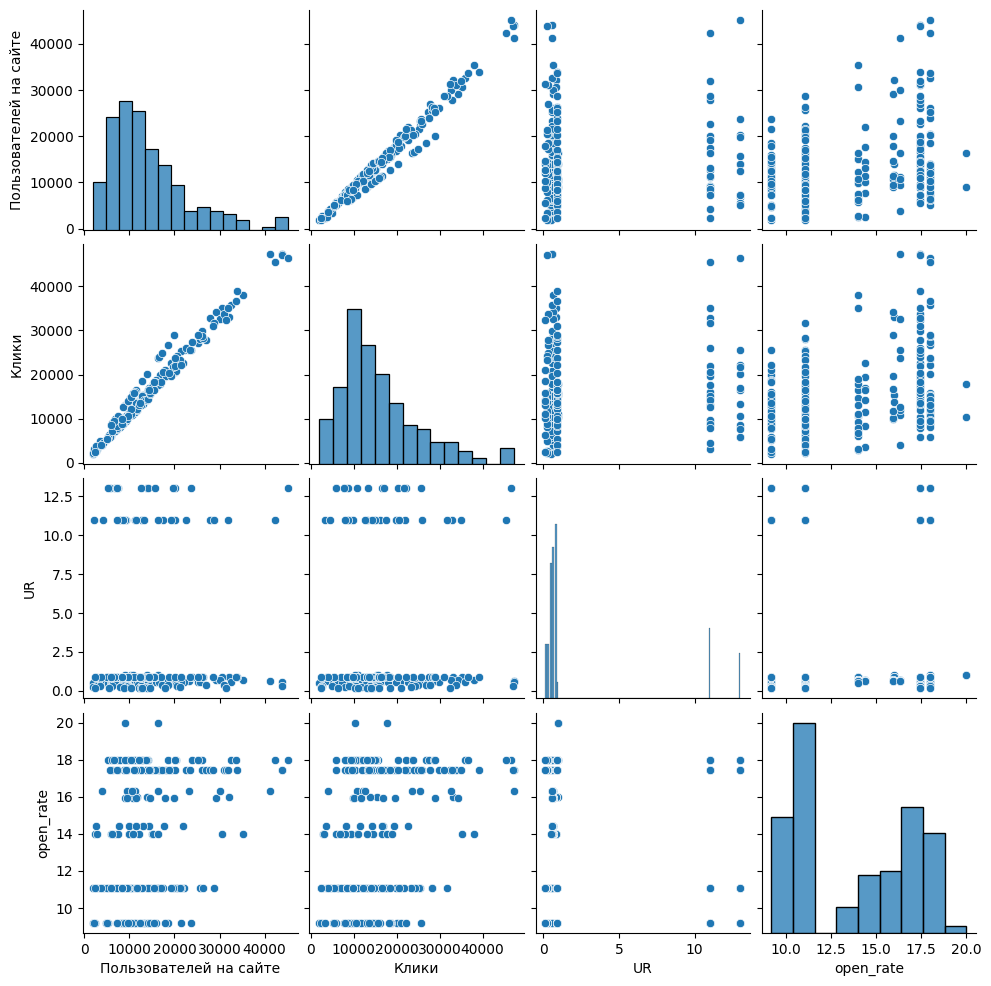

In [95]:
'''
Заметил на визуализации странное увеличение пользователей на сайте (и кликов) в момент, 
когда UR (процент отписавшихся) увеличился.

Решил посмотреть взаимосвязь между переменными. 
Если посмотреть график UR с Пользователями на сайте, то взаимосвязи мы не увидим,
однако большая часть данных расположена при значении UR менее 1% , однако выбросы по метрике UR 
никак не связаны с количеством пользователей на сайте
'''
sns.pairplot(df2[['Пользователей на сайте','Клики','UR','open_rate']]);